# Mask R-CNN - Train on Coco Dataset


In [1]:
# Import Python Packages
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import imgaug

# Import Mobile Mask R-CNN Packages
from mrcnn.config import Config
from samples.coco import coco
from mrcnn import model as modellib,utils,visualize
from mrcnn.model import log

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Coco Dataset directory
COCO_DIR = os.path.join(ROOT_DIR, 'data/coco')

Using TensorFlow backend.


## Configurations

In [3]:
class CocoConfig(Config):
    """Configuration for training on MS COCO.
    Derives from the base Config class and overrides values specific
    to the COCO dataset.
    """
    # Give the configuration a recognizable name
    NAME = "coco"

    # GPU
    IMAGES_PER_GPU = 1
    GPU_COUNT = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # COCO has 80 classes (1+80)

    # Architecture
    ARCH = "mobilenetv1"
    BACKBONE_STRIDES = [2, 4, 8, 16, 32]

    # Input Resolution
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    
config = CocoConfig()
config.display()


Configurations:
ARCH                           mobilenetv1
BACKBONE_STRIDES               [2, 4, 8, 16, 32]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'mrcnn_mask_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'rpn_class_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
M

## Notebook Preferences

In [4]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

In [5]:
# Training Dataset
classes = ['person']
dataset_train = coco.CocoDataset()
dataset_train.load_coco(COCO_DIR, "train", class_names=classes)
dataset_train.prepare()

# Validation Dataset
dataset_val = coco.CocoDataset()
dataset_val.load_coco(COCO_DIR, "val", class_names=classes)
dataset_val.prepare()

loading annotations into memory...
Done (t=13.99s)
creating index...
index created!
loading annotations into memory...
Done (t=0.49s)
creating index...
index created!


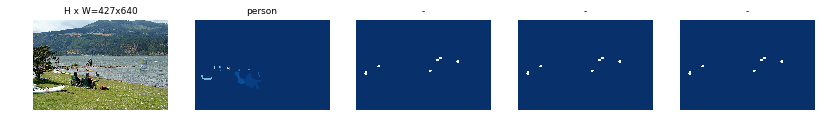

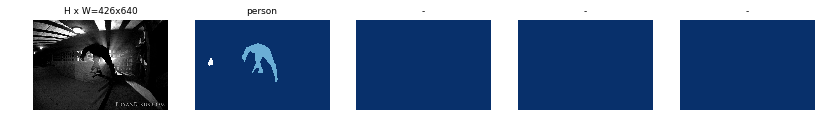

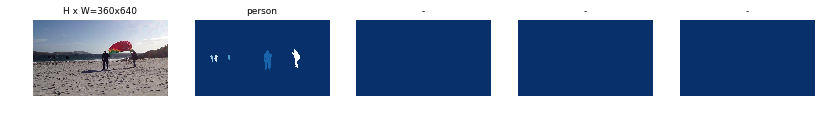

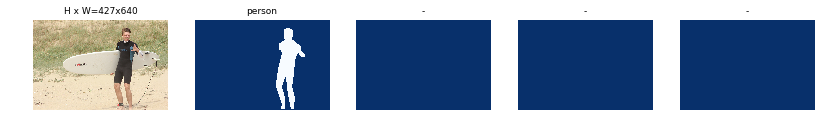

In [6]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [8]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", model_dir = MODEL_DIR, config=config)

In [9]:
# Which weights to start with?
init_weights = "imagenet"  # imagenet, coco, or last

if init_weights == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_weights == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_weights == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

## Training

In [10]:
# Augmentation
augmentation = imgaug.augmenters.Fliplr(0.5)

In [11]:
# Training - Stage 1
# Finetune network heads
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=160,
            layers='heads',
            augmentation=augmentation)

Instructions for updating:
Use the retry module or similar alternatives.

Starting at epoch 0. LR=0.001

Checkpoint Path: /home/gustav/workspace/Mobile_Mask_RCNN/logs/coco20180418T1326/mask_rcnn_coco_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
('In model: ', 'rpn_model')
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed

/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python2.7/dist-packages/keras/engine/training.py:2023: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'
ERROR:root:Error processing image {'source': 'coco', 'width': 640, 'path': u'/home/gustav/workspace/Mobile_Mask_RCNN/data/coco/train2017/000000071138.jpg', 'height': 424, 'id': 71138, 'annotations': [{u'segmentation': [[499.44, 424.0, 504.22, 402.04, 498.49, 375.3, 501.35, 360.97, 511.86, 345.69, 520.45, 340.92, 512.81, 326.59, 510.9, 315.14, 510.9, 301.77, 507.08, 285.53, 507.08, 283.62, 507.08, 262.61, 505.17, 246.

ERROR:root:Error processing image {'source': 'coco', 'width': 478, 'path': u'/home/gustav/workspace/Mobile_Mask_RCNN/data/coco/train2017/000000188866.jpg', 'height': 640, 'id': 188866, 'annotations': [{u'segmentation': [[110.49, 305.08, 129.15, 297.9, 142.06, 280.68, 156.41, 251.98, 170.76, 241.94, 153.54, 187.41, 150.67, 132.88, 146.37, 81.22, 149.24, 41.04, 179.37, 0.86, 330.04, 0.0, 353.0, 32.43, 361.61, 81.22, 358.74, 132.88, 363.05, 155.84, 341.52, 201.76, 367.35, 211.8, 383.14, 213.24, 404.66, 211.8, 421.88, 213.24, 453.45, 262.03, 457.76, 312.25, 450.58, 352.43, 421.88, 379.7, 431.93, 406.96, 416.14, 441.4, 404.66, 477.27, 401.79, 527.5, 381.7, 574.85, 344.39, 597.81, 282.69, 622.21, 243.95, 635.12, 165.02, 639.43, 103.32, 563.37, 77.49, 521.76, 116.23, 513.15, 100.45, 505.97, 73.18, 505.97, 53.09, 511.71, 43.05, 491.62, 27.26, 465.79, 14.35, 454.31, 33.0, 431.35, 67.44, 402.65, 87.53, 385.43, 106.19, 379.7, 110.49, 388.3, 134.89, 385.43, 143.5, 382.57, 142.06, 369.65, 120.54, 3

ERROR:root:Error processing image {'source': 'coco', 'width': 427, 'path': u'/home/gustav/workspace/Mobile_Mask_RCNN/data/coco/train2017/000000043451.jpg', 'height': 640, 'id': 43451, 'annotations': [{u'segmentation': [[204.22, 179.87, 179.78, 215.83, 175.46, 254.66, 148.13, 277.67, 135.19, 276.23, 125.12, 251.78, 125.12, 227.33, 119.37, 192.81, 139.51, 159.74, 189.84, 97.89, 201.35, 59.06, 212.85, 41.8, 254.56, 51.87, 247.37, 70.57, 296.27, 70.57, 337.98, 76.32, 330.79, 113.71, 325.03, 125.22, 309.21, 126.66, 309.21, 112.28, 293.39, 102.21, 287.64, 110.84, 290.52, 130.97, 304.9, 148.23, 303.46, 188.5, 286.2, 223.02, 273.26, 234.52, 251.69, 231.65, 245.93, 214.39, 243.06, 194.25, 227.24, 175.56]], u'area': 25018.065749999994, u'iscrowd': 0, u'image_id': 43451, u'bbox': [119.37, 41.8, 218.61, 235.87], u'category_id': 1, u'id': 430358}]}
Traceback (most recent call last):
  File "mrcnn/model.py", line 2224, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "mrcnn/model.py"

ERROR:root:Error processing image {'source': 'coco', 'width': 640, 'path': u'/home/gustav/workspace/Mobile_Mask_RCNN/data/coco/train2017/000000332067.jpg', 'height': 383, 'id': 332067, 'annotations': [{u'segmentation': [[183.32, 307.86, 166.11, 322.49, 174.72, 322.49, 183.32, 317.33, 181.6, 328.51, 169.55, 337.98, 161.81, 337.98, 143.73, 332.82, 133.4, 327.65, 129.96, 316.47, 152.34, 263.1, 185.91, 281.18, 216.89, 296.67, 244.43, 297.53, 250.46, 294.95, 258.2, 294.95, 254.76, 270.85, 253.9, 245.89, 236.69, 233.84, 236.69, 202.86, 240.99, 166.71, 246.15, 151.22, 258.2, 146.91, 280.58, 141.75, 363.2, 121.95, 392.47, 119.37, 410.54, 123.67, 416.57, 134.86, 420.01, 134.86, 427.76, 132.28, 437.22, 129.7, 458.74, 150.35, 457.88, 162.4, 449.27, 172.73, 450.13, 177.04, 452.71, 181.34, 442.39, 188.22, 432.06, 191.67, 428.62, 183.92, 426.03, 186.5, 420.01, 187.36, 417.43, 191.67, 409.68, 187.36, 401.07, 181.34, 395.91, 190.81, 394.19, 198.55, 384.72, 202.86, 383.86, 208.88, 388.16, 243.31, 389.0

ERROR:root:Error processing image {'source': 'coco', 'width': 493, 'path': u'/home/gustav/workspace/Mobile_Mask_RCNN/data/coco/train2017/000000424979.jpg', 'height': 500, 'id': 424979, 'annotations': [{u'segmentation': [[235.96, 273.03, 243.82, 226.97, 255.06, 200.0, 279.78, 179.78, 268.54, 141.57, 276.4, 120.22, 287.64, 102.25, 313.48, 101.12, 338.2, 117.98, 350.56, 124.72, 351.69, 153.93, 366.29, 166.29, 400.0, 178.65, 422.47, 200.0, 430.34, 225.84, 441.57, 264.04, 447.19, 306.74, 438.2, 323.6, 398.88, 313.48, 367.42, 283.15, 358.43, 280.9, 329.21, 286.52, 303.37, 285.39, 287.64, 291.01, 277.53, 298.88, 270.79, 293.26, 264.04, 285.39, 251.69, 283.15, 233.71, 275.28]], u'area': 27375.08429999999, u'iscrowd': 0, u'image_id': 424979, u'bbox': [233.71, 101.12, 213.48, 222.48], u'category_id': 1, u'id': 488821}, {u'segmentation': [[230.86, 284.35, 215.09, 240.43, 209.46, 231.42, 211.71, 215.65, 204.95, 203.27, 189.19, 195.38, 173.42, 190.88, 168.92, 185.25, 165.54, 166.1, 158.78, 144.71, 

ERROR:root:Error processing image {'source': 'coco', 'width': 640, 'path': u'/home/gustav/workspace/Mobile_Mask_RCNN/data/coco/train2017/000000180817.jpg', 'height': 428, 'id': 180817, 'annotations': [{u'segmentation': [[367.69, 404.98, 341.63, 411.49, 338.37, 409.05, 318.01, 413.94, 287.07, 402.53, 274.85, 402.53, 283.81, 412.31, 269.15, 413.12, 256.93, 400.91, 255.3, 378.1, 259.38, 364.26, 250.42, 349.6, 252.05, 321.91, 256.12, 306.44, 259.38, 283.63, 265.08, 265.72, 264.26, 250.24, 265.08, 236.4, 252.86, 231.51, 249.6, 247.8, 249.6, 263.27, 250.42, 268.16, 256.93, 278.75, 250.42, 295.85, 243.9, 295.03, 241.46, 292.59, 225.99, 287.7, 234.94, 236.4, 240.65, 210.34, 266.71, 204.64, 275.66, 191.61, 278.92, 180.2, 287.07, 159.84, 294.4, 150.07, 311.5, 150.07, 328.6, 154.14, 334.3, 172.06, 330.23, 189.16, 326.97, 193.23, 321.27, 203.01, 317.2, 211.15, 315.57, 219.3, 359.55, 249.43, 387.24, 263.27, 429.59, 288.52, 438.54, 316.21, 436.92, 330.87, 432.03, 318.65, 424.7, 312.95, 422.26, 323.5

ERROR:root:Error processing image {'source': 'coco', 'width': 640, 'path': u'/home/gustav/workspace/Mobile_Mask_RCNN/data/coco/train2017/000000553396.jpg', 'height': 424, 'id': 553396, 'annotations': [{u'segmentation': [[338.0, 285.12, 349.61, 311.77, 348.24, 313.13, 362.59, 313.82, 368.74, 320.65, 363.95, 322.7, 354.39, 322.7, 345.51, 322.7, 344.14, 328.84, 339.36, 337.73, 338.68, 356.17, 345.51, 365.05, 355.07, 371.88, 370.1, 371.2, 380.35, 354.12, 384.45, 343.87, 398.8, 334.99, 409.04, 327.48, 421.34, 337.73, 427.49, 324.06, 424.07, 307.67, 416.56, 302.89, 419.97, 293.32, 425.44, 281.71, 422.71, 275.56, 415.87, 278.98, 412.53, 278.23, 414.13, 273.44, 417.32, 270.25, 418.92, 262.79, 414.13, 262.26, 415.72, 257.47, 420.51, 255.34, 423.17, 252.15, 418.92, 246.82, 405.61, 235.11, 397.09, 229.26, 400.29, 218.61, 407.74, 213.82, 406.14, 195.94, 399.75, 183.7, 389.11, 178.37, 375.27, 178.37, 367.82, 187.42, 366.75, 200.2, 370.48, 213.5, 372.08, 227.34, 357.17, 234.26, 317.25, 254.49, 302.8

ERROR:root:Error processing image {'source': 'coco', 'width': 640, 'path': u'/home/gustav/workspace/Mobile_Mask_RCNN/data/coco/train2017/000000549471.jpg', 'height': 480, 'id': 549471, 'annotations': [{u'segmentation': [[190.11, 183.38, 202.29, 157.61, 212.6, 142.15, 236.02, 132.79, 238.36, 92.5, 256.16, 75.63, 263.66, 72.82, 280.06, 72.82, 286.61, 74.7, 298.79, 89.69, 302.54, 99.99, 288.96, 139.81, 307.23, 153.4, 316.59, 175.42, 324.09, 194.62, 320.34, 213.36, 319.41, 226.48, 312.25, 241.08, 320.06, 259.55, 328.58, 275.17, 332.84, 303.57, 325.03, 351.14, 328.58, 361.79, 340.65, 375.28, 342.07, 376.7, 310.83, 378.83, 303.02, 375.28, 303.73, 365.34, 307.99, 353.98, 301.6, 312.09, 280.29, 287.24, 263.25, 278.72, 236.27, 271.62, 219.23, 275.17, 205.03, 290.79, 202.19, 314.93, 202.19, 347.59, 202.19, 367.47, 202.9, 374.57, 193.67, 378.12, 176.63, 372.44, 168.11, 368.89, 170.95, 362.5, 182.31, 356.11, 185.86, 355.4, 178.05, 329.13, 171.66, 302.15, 173.79, 290.79, 169.53, 280.85, 178.76, 263

ERROR:root:Error processing image {'source': 'coco', 'width': 640, 'path': u'/home/gustav/workspace/Mobile_Mask_RCNN/data/coco/train2017/000000044839.jpg', 'height': 424, 'id': 44839, 'annotations': [{u'segmentation': [[449.73, 382.08, 377.31, 394.46, 348.73, 392.56, 329.67, 386.84, 304.9, 377.31, 281.08, 373.5, 265.83, 374.45, 252.49, 386.84, 240.11, 385.89, 254.4, 332.53, 257.26, 324.91, 261.07, 311.57, 275.36, 319.19, 282.98, 320.14, 273.46, 297.28, 269.64, 251.54, 284.89, 227.72, 318.24, 216.29, 372.55, 228.67, 388.75, 283.94, 382.08, 298.23, 372.55, 307.76, 399.23, 328.72, 426.86, 349.68, 454.49, 364.93]], u'area': 22100.403899999998, u'iscrowd': 0, u'image_id': 44839, u'bbox': [240.11, 216.29, 214.38, 178.17], u'category_id': 1, u'id': 1233152}, {u'segmentation': [[231.53, 381.12, 216.29, 369.69, 209.62, 345.87, 218.19, 266.79, 222.96, 242.01, 224.86, 208.67, 220.1, 181.99, 205.81, 156.26, 212.48, 128.63, 226.77, 82.89, 256.31, 20.96, 275.36, 14.29, 307.76, 28.58, 308.71, 58.12, 

    generator_output = next(self._generator)
ERROR:root:Error processing image {'source': 'coco', 'width': 640, 'path': u'/home/gustav/workspace/Mobile_Mask_RCNN/data/coco/train2017/000000113914.jpg', 'height': 512, 'id': 113914, 'annotations': [{u'segmentation': [[371.63, 510.85, 372.78, 493.59, 373.93, 483.24, 384.29, 428.01, 384.29, 392.34, 373.93, 363.58, 375.08, 333.66, 373.93, 306.05, 370.48, 285.34, 362.43, 261.18, 348.62, 231.26, 337.11, 215.16, 338.27, 194.44, 344.02, 164.53, 344.02, 141.52, 340.57, 132.31, 334.81, 120.81, 322.16, 113.91, 309.5, 111.6, 289.94, 112.76, 277.29, 116.21, 263.48, 124.26, 257.73, 132.31, 254.27, 149.57, 254.27, 159.93, 254.27, 167.98, 254.27, 174.89, 249.67, 192.14, 227.81, 208.25, 210.55, 222.06, 197.9, 231.26, 193.29, 235.87, 190.99, 240.47, 187.54, 245.07, 181.79, 255.42, 171.43, 263.48, 169.13, 273.83, 172.58, 286.49, 182.94, 296.84, 195.6, 303.75, 204.8, 311.8, 211.7, 323.31, 216.31, 329.06, 226.66, 332.51, 233.56, 331.36, 247.37, 331.36, 255.4

ERROR:root:Error processing image {'source': 'coco', 'width': 640, 'path': u'/home/gustav/workspace/Mobile_Mask_RCNN/data/coco/train2017/000000157960.jpg', 'height': 480, 'id': 157960, 'annotations': [{u'segmentation': [[276.13, 403.42, 276.13, 386.16, 256.72, 322.52, 254.56, 279.37, 250.25, 279.37, 244.85, 224.36, 258.88, 206.02, 302.02, 174.74, 304.18, 158.56, 299.87, 149.93, 307.42, 105.71, 327.91, 94.92, 350.56, 103.55, 357.03, 114.34, 360.27, 143.46, 354.88, 168.27, 346.25, 184.45, 338.7, 193.08, 346.25, 199.55, 367.82, 217.89, 373.21, 232.99, 372.13, 317.12, 384.0, 360.27, 392.63, 409.89, 381.84, 424.99, 379.69, 471.37, 279.37, 472.45, 275.06, 422.83, 275.06, 404.49]], u'area': 36622.247449999995, u'iscrowd': 0, u'image_id': 157960, u'bbox': [244.85, 94.92, 147.78, 377.53], u'category_id': 1, u'id': 205843}, {u'segmentation': [[133.75, 408.81, 110.02, 364.58, 110.02, 343.01, 111.1, 327.91, 129.44, 318.2, 129.44, 318.2, 121.89, 302.02, 122.97, 291.24, 126.2, 281.53, 131.6, 268.58,

  File "mrcnn/utils.py", line 456, in resize_image
    order=1, mode="constant", preserve_range=True)
    use_mini_mask=config.USE_MINI_MASK)
  File "/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py", line 90, in resize
ERROR:root:Error processing image {'source': 'coco', 'width': 640, 'path': u'/home/gustav/workspace/Mobile_Mask_RCNN/data/coco/train2017/000000225399.jpg', 'height': 640, 'id': 225399, 'annotations': [{u'segmentation': [[268.18, 60.09, 270.42, 51.56, 274.01, 48.42, 279.4, 47.52, 290.17, 50.66, 289.27, 68.17, 291.52, 76.25, 293.76, 79.84, 281.2, 110.81, 272.22, 132.35, 256.06, 176.38, 237.21, 214.53, 241.25, 224.85, 234.52, 236.07, 225.54, 236.07, 223.74, 231.13, 223.74, 221.26, 243.04, 162.46, 242.15, 150.79, 238.56, 130.59, 247.98, 108.15, 251.12, 89.3, 257.41, 77.63, 265.93, 76.25, 270.42, 72.21]], u'area': 4437.655949999999, u'iscrowd': 0, u'image_id': 225399, u'bbox': [223.74, 47.52, 70.02, 188.55], u'category_id': 1, u'id': 210544}, {u'segmentatio

  File "mrcnn/model.py", line 1746, in load_image_gt
    generator_output = next(self._generator)
    mode=config.IMAGE_RESIZE_MODE)
ERROR:root:Error processing image {'source': 'coco', 'width': 424, 'path': u'/home/gustav/workspace/Mobile_Mask_RCNN/data/coco/train2017/000000400477.jpg', 'height': 640, 'id': 400477, 'annotations': [{u'segmentation': [[224.06, 478.35, 224.06, 456.27, 221.85, 419.47, 214.49, 387.82, 218.17, 369.42, 224.06, 355.44, 217.43, 351.76, 216.7, 338.51, 217.43, 324.52, 225.53, 322.32, 229.21, 322.32, 229.95, 316.43, 229.95, 309.07, 232.15, 299.5, 240.25, 297.29, 248.35, 301.71, 249.82, 309.8, 249.82, 314.96, 266.75, 333.36, 268.96, 337.77, 262.33, 344.4, 253.5, 340.72, 253.5, 353.97, 260.12, 373.84, 264.54, 423.89, 259.39, 429.77, 257.18, 451.12, 254.97, 465.84, 255.71, 473.93, 260.86, 482.03, 249.08, 479.82, 241.72, 468.78, 246.87, 463.63, 245.4, 430.51, 238.04, 429.77, 232.89, 459.21, 231.42, 470.99, 232.89, 480.56, 225.53, 480.56]], u'area': 6114.169849999999,

  File "mrcnn/model.py", line 2224, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
    order=1, mode="constant", preserve_range=True)
  File "mrcnn/model.py", line 1746, in load_image_gt
  File "/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py", line 90, in resize
    mode=config.IMAGE_RESIZE_MODE)
    row_scale = float(orig_rows) / rows


Epoch 1/160


ZeroDivisionError: float division by zero

In [ ]:
# Training - Stage 2
# Finetune layers  stage 4 and up
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=120,
            layers="11M+",
            augmentation=augmentation)

In [ ]:
# Training - Stage 3
# Finetune all layers
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE / 10,
            epochs=40,
            layers='all',
            augmentation=augmentation)

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mobile_mask_rcnn_coco_person.h5")
model.keras_model.save_weights(model_path)

## Detection

In [ ]:
class InferenceConfig(MobileCocoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

In [ ]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [ ]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []

for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

In [ ]:

image_ids = np.random.choice(dataset_val.image_ids, 10)

In [ ]:
image_ids

In [ ]:
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_ids[0], use_mini_mask=False)

In [ ]:
r['masks']